# Title NN classifier for Political Bias

In [110]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

batch_size = 64

In [2]:
df = pd.read_csv("../data/source/newsclust.csv")
df = df.query("site != 'cbn.com'")
print(len(df))
df = df.sample(90000)

103262


Compute the bias for each one of the articles, based on the publication's known bias

In [3]:
from bias import Bias

num_classes = 7
df['bias'] = df.apply(lambda row: Bias.get_bias_for_domain(row['site']).value, axis=1)
df.head(2)

,Unnamed: 0,date,site,text,title,url,bias
32300,32300,2015-05-12T18:41:00.000+03:00,forbes.com,It amazes me how many people endlessly scour a...,Traveling Abroad? Spend Your Money Better - Th...,http://www.forbes.com/sites/larryolmsted/2015/...,4
78179,78179,2016-06-13T15:55:00.000+03:00,thegatewaypundit.com,"Jim Hoft Jun 13th, 2016 7:55 am Leave a Commen...",Donald Trump TRASHES Obama After #Pulse Club M...,http://www.thegatewaypundit.com/2016/06/donald...,6


Tokenize the text of the articles, create a vocabulary of words

In [4]:
import spacy
nlp = spacy.load('en')
nlp.pipeline = []

def tokenize_text(texts):
    docs = [doc for doc in nlp.pipe(texts, batch_size=500, n_threads=8)]
    return docs

def is_invalid_token(token):
    return token.is_punct or token.is_space or token.like_url or token.like_num or token.is_digit

def get_words_for_docs(docs):
    return [get_words_ids(doc) for doc in docs]

def get_words_ids(doc):
    return [token.orth for token in doc if not is_invalid_token(token)]

In [5]:
df['docs'] = tokenize_text(df['title'].astype(str))

In [6]:
df['words'] = get_words_for_docs(df['docs'])
df.head(1)

,Unnamed: 0,date,site,text,title,url,bias,docs,words
32300,32300,2015-05-12T18:41:00.000+03:00,forbes.com,It amazes me how many people endlessly scour a...,Traveling Abroad? Spend Your Money Better - Th...,http://www.forbes.com/sites/larryolmsted/2015/...,4,"(Traveling, Abroad, ?, Spend, Your, Money, Bet...","[387821, 420512, 482642, 1213, 4589, 4051, 566..."


Keep the most common words as vocabulary, replace the words out of vocabulary by the least frequently used word

In [7]:
from collections import Counter

vocab_size = 100000

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

word_freq = Counter(flatten(df['words']))
common_words = word_freq.most_common(vocab_size)
word_freq.most_common(5)

[(504, 18293), (576246, 14773), (522, 12724), (501, 11675), (566, 11541)]

In [8]:
print(nlp.vocab.strings[501], nlp.vocab.strings[510], nlp.vocab.strings[512], nlp.vocab.strings[506])

the of and a


In [9]:
vocab = {word_id: i for (i, (word_id, freq)) in enumerate(common_words)}
print(len(vocab), vocab[501], vocab[504], vocab[510])
oov_word = vocab_size - 1
oov_word

66163 3 0 5


99999

In [10]:
def get_words_ids_if_common(words):
    return [vocab.get(word, oov_word) for word in words]

df['words_with_oov'] = df.apply(lambda row: get_words_ids_if_common(row['words']), axis=1)
df['words_with_oov'].head()

32300    [10013, 7762, 4951, 186, 442, 1105, 4, 402, 40...
78179    [39, 1, 18125, 17, 31, 7617, 1398, 1860, 43, 1...
36207    [3482, 17, 1740, 0, 6585, 281, 6, 209, 128, 70...
17883    [9376, 268, 34329, 3597, 9308, 142, 1, 6, 631,...
64001    [1153, 4288, 574, 1684, 2030, 250, 16, 211, 49...
Name: words_with_oov, dtype: object

Look at the distribution of words. The longest article has 15K words, the shortest 21.

In [11]:
lens = np.array(list(map(len, df['words'])))
(lens.max(), lens.min(), lens.mean())

(45, 0, 11.103877777777777)

Split the data for training and validation

In [12]:
TEST_DOMAINS =  {
    'bloomberg.com',
     'breitbart.com',
     'c-span.org',
     'chicagotribune.com',
     'chron.com'
}
df_train =  df.loc[~df['site'].isin(TEST_DOMAINS)]
df_test =  df.loc[df['site'].isin(TEST_DOMAINS)]
print(len(df_train))
print(len(df_test))

82275
7725


Enforce all texts to have the same length, truncating or padding if necessary

In [13]:
seq_len = 50

from keras.preprocessing import sequence

trn = sequence.pad_sequences(df_train['words_with_oov'], maxlen=seq_len, value=0)
test = sequence.pad_sequences(df_test['words_with_oov'], maxlen=seq_len, value=0)

trn

Using TensorFlow backend.


array([[    0,     0,     0, ...,  2226,    13,   496],
       [    0,     0,     0, ...,    92, 15048,    35],
       [    0,     0,     0, ...,     8,    32,    59],
       ..., 
       [    0,     0,     0, ...,   879,     8,   884],
       [    0,     0,     0, ...,     5,     3, 47143],
       [    0,     0,     0, ...,   483,  4009,  5489]], dtype=int32)

## Single Hidden Layer NN classifier

### Keras NN model

In [74]:
# Force use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Convolution1D, MaxPooling1D
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import Adam

In [58]:
k_model = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')])

In [59]:
k_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
#k_model.summary()

In [60]:
from keras.utils.np_utils import to_categorical

labels_train = np.array(df_train['bias'])
labels_test = np.array(df_test['bias'])

k_model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=batch_size)

Train on 82275 samples, validate on 7725 samples
Epoch 1/2
82275/82275 [==============================] - 56s - loss: 1.2666 - acc: 0.4910 - val_loss: 1.0635 - val_acc: 0.6179
Epoch 2/2
82275/82275 [==============================] - 57s - loss: 0.7189 - acc: 0.7385 - val_loss: 1.1796 - val_acc: 0.5423


Manually verify some articles. The bias for these articles should match the predicted bias below.

In [68]:
df_sample = df_test.sample(5)
df_sample[['site', 'title', 'bias']]

,site,title,bias
42460,breitbart.com,Illegal Alien Health Insurance Expanded in 35 ...,5
99170,breitbart.com,Oregon Medicaid Paying for Sex Changes for 15-...,5
103964,chron.com,Montrose County deputy helps find trunk load o...,2
105149,chicagotribune.com,How the red light camera study was done - Chic...,2
92605,bloomberg.com,BENEFIT ONE INC (2412:Tokyo): Pensions & Stock...,2


In [143]:
sample = sequence.pad_sequences(df_sample['words_with_oov'], maxlen=seq_len, value=0)
prediction = np.argmax(k_model.predict(test), axis=1)
print("precision = ", np.sum(prediction == labels_test) * 100.0 / len(labels_test))
df_prediction, df_prediction['bias'] = df_sample[['site', 'title']], np.argmax(k_model.predict(sample), axis=1)
df_prediction

precision =  54.2265372168


/Users/rodrigo/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,site,title,bias
42460,breitbart.com,Illegal Alien Health Insurance Expanded in 35 ...,5
99170,breitbart.com,Oregon Medicaid Paying for Sex Changes for 15-...,5
103964,chron.com,Montrose County deputy helps find trunk load o...,2
105149,chicagotribune.com,How the red light camera study was done - Chic...,2
92605,bloomberg.com,BENEFIT ONE INC (2412:Tokyo): Pensions & Stock...,4


In [144]:
cm = confusion_matrix(labels_test, predictions)
cm

array([[   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   1,  538, 2796,  339, 1002,  347,   46],
       [   0,   85,   45,  827,   47,   54,    2],
       [   0,    0,    0,    0,    0,    0,    0],
       [   2,  734,  140,   19,   73,  524,  104],
       [   0,    0,    0,    0,    0,    0,    0]])

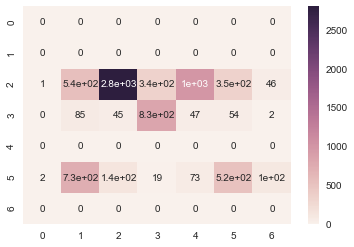

In [145]:
sn.heatmap(cm, annot=True)

## CNN with MaxPool NN classifier

In [89]:
conv1 = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, dropout=0.2),
    Dropout(0.2),
    Convolution1D(32, 5, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')])

conv1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# conv1.summary()

In [90]:
conv1.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=3, batch_size=batch_size)

/Users/rodrigo/pytorch/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 82275 samples, validate on 7725 samples
Epoch 1/3
82275/82275 [==============================] - 366s - loss: 1.3628 - acc: 0.4340 - val_loss: 1.0501 - val_acc: 0.6808
Epoch 2/3
82275/82275 [==============================] - 196s - loss: 1.0302 - acc: 0.5971 - val_loss: 1.1141 - val_acc: 0.5846
Epoch 3/3
82275/82275 [==============================] - 198s - loss: 0.8659 - acc: 0.6733 - val_loss: 1.0325 - val_acc: 0.6032


In [133]:
predictions = np.argmax(conv1.predict(test), axis=1)
print("precision = ", np.sum(predictions == labels_test) * 100.0 / len(labels_test))
df_prediction, df_prediction['bias'] = df_sample[['site', 'title']], np.argmax(conv1.predict(sample), axis=1)
df_prediction

precision =  52.5177993528


/Users/rodrigo/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,site,title,bias
42460,breitbart.com,Illegal Alien Health Insurance Expanded in 35 ...,5
99170,breitbart.com,Oregon Medicaid Paying for Sex Changes for 15-...,5
103964,chron.com,Montrose County deputy helps find trunk load o...,2
105149,chicagotribune.com,How the red light camera study was done - Chic...,2
92605,bloomberg.com,BENEFIT ONE INC (2412:Tokyo): Pensions & Stock...,4


In [134]:
cm = confusion_matrix(labels_test, predictions)
cm

array([[   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   1,  368, 2730,  298, 1171,  440,   61],
       [   0,   66,   76,  650,   52,  211,    5],
       [   0,    0,    0,    0,    0,    0,    0],
       [   3,  576,  135,   11,   84,  677,  110],
       [   0,    0,    0,    0,    0,    0,    0]])

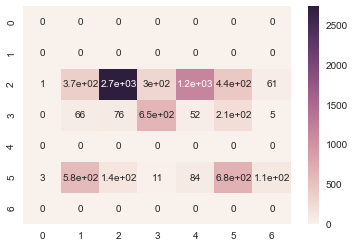

In [135]:
sn.heatmap(cm, annot=True)

## Multi-size CNN

This gives the best performance at around 60% accuracy

In [100]:
from keras.layers import Merge, Input

graph_in = Input ((vocab_size, 50))
convs = [ ] 
for fsz in range (3, 6): 
    x = Convolution1D(64, fsz, border_mode='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
out = Merge(mode="concat")(convs) 
graph = Model(graph_in, out)

In [102]:
multi_size_cnn = Sequential ([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2),
    Dropout (0.3),
    graph,
    Dropout (0.5),
    Dense (100, activation="relu"),
    Dropout (0.3),
    Dense (7, activation='softmax')
    ])

multi_size_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# conv1.summary()

In [103]:
multi_size_cnn.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=batch_size)

/Users/rodrigo/pytorch/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 82275 samples, validate on 7725 samples
Epoch 1/3
82275/82275 [==============================] - 679s - loss: 1.3023 - acc: 0.4634 - val_loss: 1.0487 - val_acc: 0.6452
Epoch 2/3
82275/82275 [==============================] - 326s - loss: 0.9870 - acc: 0.6160 - val_loss: 1.0425 - val_acc: 0.6047
Epoch 3/3
 7680/82275 [=>............................] - ETA: 302s - loss: 0.7830 - acc: 0.7051

KeyboardInterrupt: 

In [140]:
predictions = np.argmax(multi_size_cnn.predict(test), axis=1)
print("precision = ", np.sum(predictions == labels_test) * 100.0 / len(labels_test))
df_prediction, df_prediction['bias'] = df_sample[['site', 'title']], np.argmax(multi_size_cnn.predict(sample), axis=1)
df_prediction

precision =  53.6828478964


/Users/rodrigo/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,site,title,bias
42460,breitbart.com,Illegal Alien Health Insurance Expanded in 35 ...,5
99170,breitbart.com,Oregon Medicaid Paying for Sex Changes for 15-...,5
103964,chron.com,Montrose County deputy helps find trunk load o...,2
105149,chicagotribune.com,How the red light camera study was done - Chic...,2
92605,bloomberg.com,BENEFIT ONE INC (2412:Tokyo): Pensions & Stock...,4


In [141]:
cm = confusion_matrix(labels_test, predictions)
cm

array([[   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   1,  538, 2796,  339, 1002,  347,   46],
       [   0,   85,   45,  827,   47,   54,    2],
       [   0,    0,    0,    0,    0,    0,    0],
       [   2,  734,  140,   19,   73,  524,  104],
       [   0,    0,    0,    0,    0,    0,    0]])

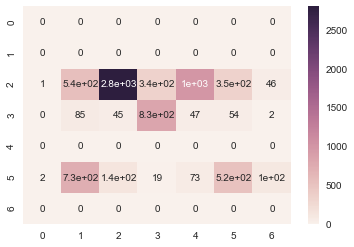

In [142]:
sn.heatmap(cm, annot=True)

## Site vectors

Remove the last linear classifier

In [ ]:
l4 = k_model.pop()
l3 = k_model.pop()

In [ ]:
k_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
k_model.summary()

In [ ]:
article_vectors = k_model.predict(trn)
article_vectors.shape

Generate an average vector of all the article vectors for each site

In [ ]:
site_vectors = []
labels = []
sample_size = 1000
for site in df_train['site'].unique():
    site_indexes = np.where(df_train["site"] == site)[0]
    if len(site_indexes) > 0:
        site_vector = np.mean(article_vectors[site_indexes[:sample_size], :], axis=0)
        site_vectors.append(site_vector)
        labels.append(site)
site_vectors = np.array(site_vectors)
site_vectors.shape

In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
site_vectors_2_dim = tsne_model.fit_transform(site_vectors)
X_proj = site_vectors_2_dim[:, 0]
Y_proj = site_vectors_2_dim[:, 1]

In [ ]:
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from plotly.graph_objs import Bar, Scatter, Figure, Layout, XAxis, YAxis

In [ ]:
trace = Scatter(x=X_proj, y=Y_proj, mode='markers+text', text=labels, textposition='top',  marker=dict(size=10))
iplot({
    'data': [trace],
    'layout': Layout(
        #xaxis=XAxis(title='Left vs Right'), 
        #yaxis=YAxis(title='Biased vs Factual'),
        autosize=False,
        width=1000,
        height=700)},
    show_link=False
)

### PCA Analysis

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
site_vectors_pca = pca.fit(site_vectors).components_

In [ ]:
trace = Scatter(x=site_vectors_pca[0], y=site_vectors_pca[1], mode='markers+text', text=labels, textposition='top',  marker=dict(size=10))
iplot({
    'data': [trace],
    'layout': Layout(
        #xaxis=XAxis(title='Left vs Right'), 
        #yaxis=YAxis(title='Biased vs Factual'),
        autosize=False,
        width=1000,
        height=700)},
    show_link=False
)